# Setting up Enviroment

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
%matplotlib inline

In [2]:
tf.__version__

'2.0.0-beta1'

In [3]:
tf.test.is_gpu_available()

True

**Using Half Precision FP-16**

In [4]:
dtype='float16'
K.set_floatx(dtype)

# default is 1e-7 which is too small for float16.  Without adjusting the epsilon, we will get NaN predictions because of divide by zero problems
K.set_epsilon(1e-4) 

# Getting the Data

In [5]:
filenames = os.listdir("train")
print("No of images: ", len(filenames))

No of images:  25000


In [6]:
category = []
for file in filenames:
    if file[0] == 'd':
        category.append('1')
    if file[0] == 'c':
        category.append('0')

In [7]:
data = pd.DataFrame({'Photo': filenames, 'Class': category})
data = data.sample(frac = 1, replace = False, random_state = 0)
data.reset_index(drop = True, inplace = True)
data.head()

,Photo,Class
0,dog.11481.jpg,1
1,cat.680.jpg,0
2,dog.7639.jpg,1
3,cat.9695.jpg,0
4,cat.3139.jpg,0


# Displaying 10 examples

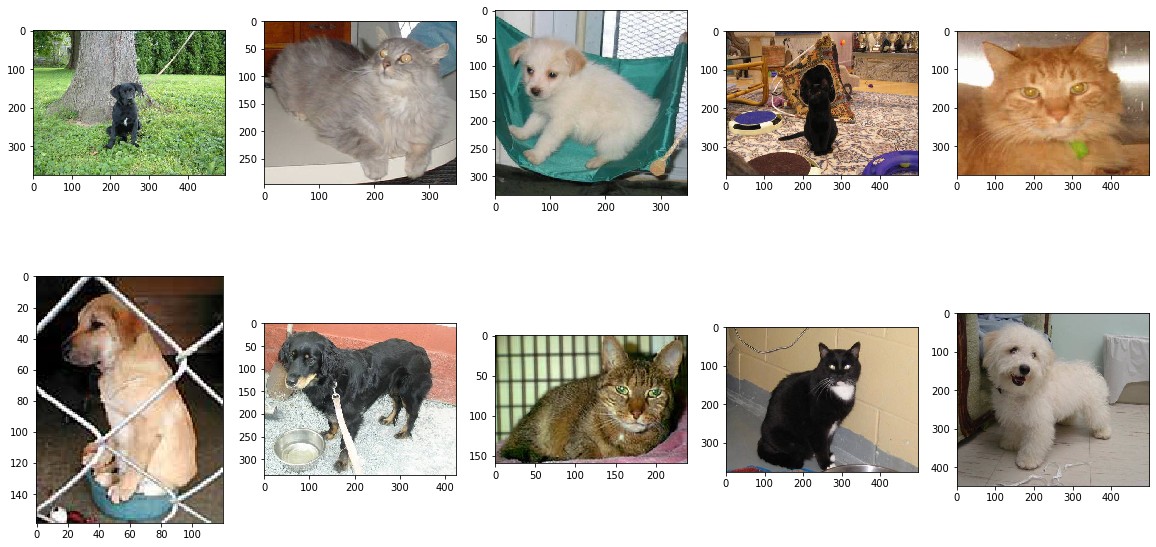

In [8]:
fig = plt.figure(figsize = (20,10))
for i in range(10):
    img = plt.imread("train/" + data['Photo'].iloc[i]) 
    plt.subplot(2,5,i+1)
    plt.imshow(img)    
plt.show()

# Splitting the Data into Train and Validation

In [9]:
train_data = data.iloc[:20000]
valid_data = data.iloc[20000:]

In [10]:
train_data.head()

,Photo,Class
0,dog.11481.jpg,1
1,cat.680.jpg,0
2,dog.7639.jpg,1
3,cat.9695.jpg,0
4,cat.3139.jpg,0


In [11]:
valid_data.head()

,Photo,Class
20000,dog.12333.jpg,1
20001,dog.11732.jpg,1
20002,cat.11927.jpg,0
20003,cat.3992.jpg,0
20004,cat.11303.jpg,0


# Number of Trainable layers in a model

In [12]:
def num_trainable_layers(model):
    count = 0
    for layer in model.layers:
        if layer.trainable == True:
            count += 1
    print("Number of Trainable Layers: ", count)

# Creating the Train and Validation Image Generators

In [13]:
train_datagen = ImageDataGenerator(rotation_range = 30,
                                   width_shift_range = 0.25,
                                   height_shift_range = 0.25,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   brightness_range = [0.75, 1.25],
                                   preprocessing_function = preprocess_input) 

valid_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [14]:
train_generator = train_datagen.flow_from_dataframe(train_data,
                                                    directory = 'train/',
                                                    x_col = 'Photo',
                                                    y_col = 'Class',
                                                    target_size = (299,299),
                                                    class_mode = 'binary',
                                                    seed = 42,
                                                    batch_size = 64)

validation_generator = valid_datagen.flow_from_dataframe(valid_data,
                                                    directory = 'train/',
                                                    x_col = 'Photo',
                                                    y_col = 'Class',
                                                    target_size = (299,299),
                                                    class_mode = 'binary',
                                                    seed = 42,
                                                    batch_size = 64)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


# Using InceptionV3 as the base CNN model

In [15]:
inceptionv3 = InceptionV3(include_top = False,
                           weights = 'imagenet',
                           input_shape = (299, 299, 3),
                           pooling = 'avg',
                           classes = 2)

**Freezing the Base Model**

In [16]:
inceptionv3.trainable = False

**Adding Dense Layer at the end**

In [17]:
out = Dense(1, activation = 'sigmoid')(inceptionv3.output)
model = Model(inputs = inceptionv3.inputs, outputs = out)

num_trainable_layers(model)

Number of Trainable Layers:  1


In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Compiling and Training the Model

In [19]:
optim = tf.keras.optimizers.Adam(lr = 0.001)
model.compile(optimizer = optim, loss = 'binary_crossentropy', metrics = ['accuracy'])

**Training only the Last (Dense) layer**

In [20]:
hist = model.fit_generator(train_generator,
                           steps_per_epoch = len(train_generator),
                           epochs = 20,
                           validation_data = validation_generator,
                           verbose = 2,
                           validation_steps = len(validation_generator),
                           validation_freq = 1)

Epoch 1/20


W0920 14:08:01.548494 14388 deprecation.py:323] From C:\Users\RAJDEEP\Anaconda\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


313/313 - 510s - loss: 0.6977 - accuracy: 0.7539 - val_loss: 0.1907 - val_accuracy: 0.9224
Epoch 2/20
313/313 - 492s - loss: 0.2307 - accuracy: 0.9209 - val_loss: 0.1629 - val_accuracy: 0.9375
Epoch 3/20
313/313 - 495s - loss: 0.1719 - accuracy: 0.9463 - val_loss: 0.1458 - val_accuracy: 0.9463
Epoch 4/20
313/313 - 493s - loss: 0.1462 - accuracy: 0.9614 - val_loss: 0.1062 - val_accuracy: 0.9648
Epoch 5/20
313/313 - 485s - loss: 0.1420 - accuracy: 0.9624 - val_loss: 0.0598 - val_accuracy: 0.9849
Epoch 6/20
313/313 - 481s - loss: 0.1284 - accuracy: 0.9663 - val_loss: 0.0707 - val_accuracy: 0.9814
Epoch 7/20
313/313 - 476s - loss: 0.1253 - accuracy: 0.9678 - val_loss: 0.0950 - val_accuracy: 0.9727
Epoch 8/20
313/313 - 481s - loss: 0.1171 - accuracy: 0.9722 - val_loss: 0.1140 - val_accuracy: 0.9648
Epoch 9/20
313/313 - 483s - loss: 0.1159 - accuracy: 0.9722 - val_loss: 0.0898 - val_accuracy: 0.9761
Epoch 10/20
313/313 - 486s - loss: 0.1191 - accuracy: 0.9702 - val_loss: 0.0796 - val_accurac

# Saving the Model

In [21]:
model.save("model_before_finetuning.h5")

We save the model, in case we want to finetune the model at a later time. In that case, re-run the first cell to import the necessary modules and also initialize the Training and Validation Image Data Genartors. Then we load the saved model by running the following cell.

# Loading the Model

In [15]:
model = load_model("model_before_finetuning.h5")

W0920 18:56:22.156484 17052 deprecation.py:323] From C:\Users\RAJDEEP\Anaconda\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Finetuning the Model

**Unfreezing the Base Model**

In [16]:
model.trainable = True
num_trainable_layers(model)

Number of Trainable Layers:  313


**Using Checkpoints**

In [17]:
checkpoint = ModelCheckpoint('checkpoint.h5',
                             monitor = 'val_accuracy',
                             verbose = 0,
                             save_best_only = True,
                             save_weights_only = False, 
                             mode = 'max',
                             save_freq = 'epoch')

**Re-Compiling the Model**

In [18]:
optim = tf.keras.optimizers.Adam(lr = 0.00001)
model.compile(optimizer = optim, loss = 'binary_crossentropy', metrics = ['accuracy'])

**Training all the layers**

In [19]:
hist = model.fit_generator(train_generator,
                           steps_per_epoch = len(train_generator),
                           epochs = 30,
                           callbacks = [checkpoint],
                           validation_data = validation_generator,
                           verbose = 2,
                           validation_steps = len(validation_generator),
                           validation_freq = 1)

Epoch 1/30
313/313 - 619s - loss: 0.0953 - accuracy: 0.9800 - val_loss: 0.0456 - val_accuracy: 0.9849
Epoch 2/30
313/313 - 530s - loss: 0.0851 - accuracy: 0.9839 - val_loss: 0.0473 - val_accuracy: 0.9824
Epoch 3/30
313/313 - 534s - loss: 0.0883 - accuracy: 0.9814 - val_loss: 0.0455 - val_accuracy: 0.9824
Epoch 4/30
313/313 - 524s - loss: 0.0827 - accuracy: 0.9849 - val_loss: 0.0455 - val_accuracy: 0.9858
Epoch 5/30
313/313 - 528s - loss: 0.0839 - accuracy: 0.9839 - val_loss: 0.0445 - val_accuracy: 0.9873
Epoch 6/30
313/313 - 525s - loss: 0.0796 - accuracy: 0.9839 - val_loss: 0.0454 - val_accuracy: 0.9858
Epoch 7/30
313/313 - 543s - loss: 0.0795 - accuracy: 0.9858 - val_loss: 0.0429 - val_accuracy: 0.9858
Epoch 8/30
313/313 - 543s - loss: 0.0740 - accuracy: 0.9863 - val_loss: 0.0435 - val_accuracy: 0.9858
Epoch 9/30
313/313 - 538s - loss: 0.0738 - accuracy: 0.9863 - val_loss: 0.0413 - val_accuracy: 0.9873
Epoch 10/30
313/313 - 533s - loss: 0.0826 - accuracy: 0.9834 - val_loss: 0.0390 - 

# Saving the Final Model

Since after the last epoch, we see that model has attained its best score in terms of both Training and Validation Accuracy, we are going to save the model and use it to predict the Test Cases.

In [20]:
model.save("final_model.h5")

# Evaluating the Model

In [21]:
train_loss, train_acc = model.evaluate_generator(train_generator, steps = len(train_generator))
print("Train Loss: ", train_loss)
print("Train Acc: ", train_acc)

Train Loss:  0.04048780359018344
Train Acc:  0.995


In [22]:
validation_loss, validation_acc = model.evaluate_generator(validation_generator, steps = len(validation_generator))
print("Validation Loss: ", validation_loss)
print("Validation Acc: ", validation_acc)

Validation Loss:  0.033245949805537356
Validation Acc:  0.992


# Getting the Test Data

In [23]:
test_filenames = os.listdir("test")
print("No of images: ", len(test_filenames))

No of images:  12500


In [24]:
test_data = pd.DataFrame({'Photo': test_filenames})
test_data.reset_index(drop = True, inplace = True)
test_data.head()

,Photo
0,1.jpg
1,10.jpg
2,100.jpg
3,1000.jpg
4,10000.jpg


# Creating the Test Image Generators

In [25]:
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

test_generator = test_datagen.flow_from_dataframe(test_data,
                                                  directory = 'test',
                                                  x_col = 'Photo',
                                                  target_size = (299,299),
                                                  class_mode = None,
                                                  shuffle = False,
                                                  batch_size = 64)

Found 12500 validated image filenames.


# Predicting the Test Examples

In [26]:
out = model.predict_generator(test_generator,
                        steps = len(test_generator),
                        verbose=0)

print("Shape of Test Prediction Array:", out.shape)

Shape of Test Prediction Array: (12500, 1)


# Creating the Output CSV

In [27]:
df = pd.DataFrame({'id': test_filenames, 'label':out.squeeze()})
df.head()

,id,label
0,1.jpg,1.000000
1,10.jpg,0.000000
2,100.jpg,0.000532
3,1000.jpg,1.000000
4,10000.jpg,1.000000


In [28]:
df['id'] = df['id'].str.split(".", expand = True).iloc[:,0].astype(int)
df = df.sort_values('id').reset_index(drop = True)
df.head()

,id,label
0,1,1.000000
1,2,1.000000
2,3,0.999023
3,4,1.000000
4,5,0.000017


In [29]:
df.to_csv("out.csv", index = False)

**This model gave a score (LogLoss) of 0.14932 on the Test Dataset.**